In [1]:
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
df = pd.read_csv("data/TAQ_15Min_AAPL_2023.csv")
df.index = df.datetime
N_day = 26
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6500 entries, 2023-01-03 09:30:00 to 2023-12-29 15:45:00
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   datetime   6500 non-null   object 
 1   OPEN       6500 non-null   float64
 2   HIGH       6500 non-null   float64
 3   LOW        6500 non-null   float64
 4   CLOSE      6500 non-null   float64
 5   AVG_PRICE  6500 non-null   float64
 6   VOLUME     6500 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 406.2+ KB


In [3]:
def predict_volumes(mu, Sigma, true_volumes):
    """
    param mu: means
    param Sigma: covariance
    param true_volumes: true volumes, i.e., means[0] predicts true_volumes[0]
    """
    n= mu.shape[0]
    
    predictions = np.zeros(n)
    predictions[0] = mu[0]
    
    for i in range(1,n):
        ### following Wikipedia's notation, we observe x2 and update x1
        
        mu1 = mu[i:]
        mu2 = mu[:i]
        a = true_volumes[:i]
        
        mu_bar = mu[i:]
        Sigma_12 = Sigma[i:, :i]
        Sigma_22 = Sigma[:i, :i]
        Sigma_21 = Sigma[:i, i:]
#         assert Sigma_21 == Sigma_12.T

        mu_bar = mu1 + Sigma_12 @ np.linalg.inv(Sigma_22) @ (a-mu2)
        
        predictions[i] = mu_bar[0]
    
    return predictions
    


In [7]:
X1 = pd.DataFrame(df["VOLUME"])
X1.index = pd.to_datetime(X1.index)
grouped = X1.groupby(pd.Grouper(freq='1d'))
bad_ts = []
for (t,g) in grouped:
    if g.shape[0] == N_day or g.shape[0] == 0:
        pass
    else:
        print("Bad timestamp: {} has size {}".format(t, g.shape[0]))
        bad_ts.append(t)

# Delete the days that have truncated data
for bad_t in bad_ts:
    nxt = pd.Timestamp(year=bad_t.year, month=bad_t.month, day=bad_t.day+1)
    X1 = X1[~(X1.index < nxt) & (X1.index > bad_t)]

In [8]:
N = X1.shape[0]
X = X1.to_numpy().reshape(int(N/N_day), N_day)
X.shape

(250, 26)

In [9]:
def lag_col(pd_col, i):
    d = {"VOLUME" : "VOLUME_{}".format(N_day-i)}
    pd_col.rename(columns=d, inplace=True)
    return pd_col.shift(-i)[:-N_day-1]

#X1 = pd.concat([lag_col(pd.DataFrame(df["VOLUME"]), i) for i in range(N_day)], axis=1)
#X = X1.to_numpy() # this constructs a lagged matrix but I don't know why this makes sense

In [10]:
np.random.seed(0)

A = np.random.normal(size=(N_day,N_day))

Sigma = A@A.T

#X = np.random.multivariate_normal(np.zeros(10),Sigma, 1000)

mu = X.mean(axis=0)

benchmark_error = ((X-mu)**2).mean()
# so we would do N_day-1 updates per row since we have N_day columns 

mu = X.mean(axis=0)
Sigma = np.cov(X[:-1].T)
true_volumes = X[-1]

pred = predict_volumes(mu, Sigma, true_volumes)
print(f"MSE without mean update: {((mu-true_volumes)**2).mean()}")
print(f"MSE with mean update: {((pred-true_volumes)**2).mean()}")

MSE without mean update: 1164117756412.9934
MSE with mean update: 850300478464.9916


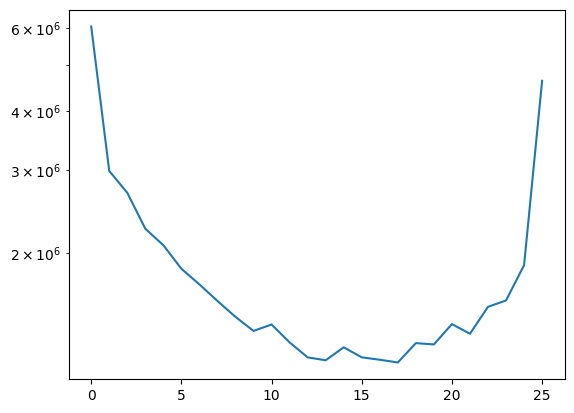

In [11]:
plt.semilogy(mu)

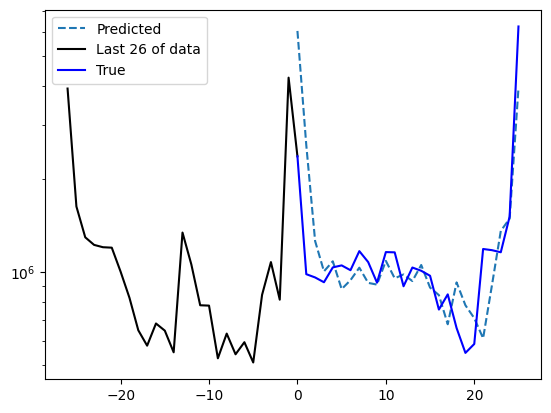

In [13]:
plt.semilogy(range(N_day), pred, label="Predicted", linestyle="dashed")
plt.semilogy(range(-N_day,1), X1["VOLUME"][-N_day*2:-N_day+1], label="Last {} of data".format(N_day), color="black")
plt.semilogy(range(N_day), true_volumes, label="True", color="blue")
plt.legend()